# REZ capacity factors

- Compare mean capacity factors computed with various datasets

In [190]:
client.close()
cluster.close()

INFO:dask_jobqueue.pbs:Resource specification for PBS not set, initializing it to select=1:ncpus=24:mem=90GB


In [ ]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [ ]:
PROJECT = "dt6"

In [14]:
walltime = "00:30:00"
cores = 24
memory = str(4 * cores) + "GB"

cluster = PBSCluster(
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    processes=cores,
    job_extra_directives=[
        "-q normal",
        "-P "+PROJECT,
        "-l ncpus="+str(cores),
        "-l mem="+str(memory),
        "-l storage=gdata/xp65+gdata/w42+scratch/w42+gdata/gb02+scratch/gb02+gdata/ng72+scratch/ng72+gdata/rt52"
    ],
    local_directory="$TMPDIR",
    job_directives_skip=["select"],
    log_directory="/scratch/w42/dr6273/tmp/logs"
)

INFO:dask_jobqueue.pbs:Resource specification for PBS not set, initializing it to select=1:ncpus=24:mem=90GB
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37831 instead
  warnings.warn(
ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-47933' coro=<Client._gather.<locals>.wait() done, defined at /g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/client.py:2377> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/client.py", line 2386, in wait
    raise AllExit()
distributed.client.AllExit
2025-10-10 11:49:10,453 - distributed.scheduler - ERROR - Task ('original-open_dataset-REZ-1d3bfd05ead9ae59061d4a16c0fff951', 0, 0, 0) m

In [15]:
cluster.scale(jobs=1)
client = Client(cluster)

INFO:dask_jobqueue.pbs:Resource specification for PBS not set, initializing it to select=1:ncpus=24:mem=90GB


In [23]:
client

<Client: 'tcp://10.6.121.3:38587' processes=24 threads=24, memory=89.52 GiB>

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
# import rioxarray
# import glob

# import matplotlib.pyplot as plt

In [3]:
%cd /g/data/w42/dr6273/work/wind_power_comparison/
import functions as fn

/g/data/w42/dr6273/work/wind_power_comparison


In [4]:
%load_ext autoreload
%autoreload 2

## Load data

BARRA-C2 Capacity factor

In [5]:
rez_mask_barra_c2 = xr.open_dataset(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/rez_2024_mask_BARRA-C2_grid.nc"
)["REZ"]

In [6]:
cf_barra = fn.load_barra_c2_capacity_factor().cf100m

In [7]:
cf_barra

<xarray.DataArray 'cf100m' (time: 341856, lat: 737, lon: 506)> Size: 510GB
dask.array<concatenate, shape=(341856, 737, 506), dtype=float32, chunksize=(72, 737, 506), chunktype=numpy.ndarray>
Coordinates:
    crs      int32 4B ...
    height   float64 8B ...
  * lat      (lat) float64 6kB -43.37 -43.33 -43.29 ... -14.01 -13.97 -13.93
  * lon      (lon) float64 4kB 133.5 133.5 133.6 133.6 ... 153.6 153.7 153.7
  * time     (time) datetime64[ns] 3MB 2011-01-01 ... 2023-12-31T23:40:00

Global wind Atlas

- 2008-2017 wind speed climatology

In [8]:
rez_mask_gwa = xr.open_mfdataset(
    '/g/data/w42/dr6273/work/projects/wind_comparison/rez_2024_mask_GWA_grid.nc'
)["REZ"].compute()

In [9]:
gwa_cf = fn.capacity_factor_vdW(
    fn.open_gwa_windspeed()
)

REZ mask

Wind farms

- From Palmer et al (2025): https://www.publish.csiro.au/es/fulltext/ES24028
- Thanks to Rachael Isphording for retrieving the paper's data

In [10]:
# aemc_farms = pd.read_csv(
#     "/g/data/ng72/ri9247/data/working_wind_farm_locations_AEMC_16Sept2025.csv",
#     index_col=0
# )

In [11]:
# aemc_farms[aemc_farms["Regcap"] > 0].head()

In [12]:
# r = pd.read_csv(
#     "/g/data/ng72/ri9247/data/rez_metadata.csv",
#     index_col=0
# )

### Compute REZ means

BARRA-C2

In [13]:
def compute_rez_means_barra_c2(cf_da, sampling_frequency="20min"):
    """
    Compute the REZ mean capacity factor for BARRA-C2.
    Option to only select every X time steps - assumes 20min input data, and X-hourly data will select
     each time step that coincides with the hour (not 20mins past etc.).

    cf_da: array, capacity factors
    sampling_frequency: str, "20min" or "Xhr", where X indicates every X-hourly time step
    """
    if sampling_frequency == "20min":
        skip = None
    elif sampling_frequency[-2:] == "hr":
        skip = int(sampling_frequency[:-2]) * 3 # *3 because assumes 20min input data and 0000 first timestep
    else:
        raise ValueError("Incorrect sampling_frequency specified")

    # Set up empty DataFrame
    rez_means = pd.DataFrame(index=rez_mask_barra_c2.region.values, columns=["raw_mean", "raw_weighted_mean"])
    
    # Select desired time steps
    cf_da = cf_da.sel(time=slice(None, None, skip))
    
    # Loop through REZs and compute mean
    for r in rez_means.index[:]:
        # Select REZ grid cells
        r_cf = cf_da.where(rez_mask_barra_c2.sel(region=r), drop=True)

        # Time-mean (used for arithmetic and weighted means
        r_cf_timemean = r_cf.mean("time", skipna=True).persist()
        
        # Arithmetic mean
        rez_means.loc[r, "raw_mean"] = r_cf_timemean.mean().values

        # Weighted mean
        r_cf_weighted = r_cf.weighted(r_cf_timemean.fillna(0))
        rez_means.loc[r, "raw_weighted_mean"] = r_cf_weighted.mean().values
        
    # Write the capacity factor stats to file
    rez_means.to_csv(
        "/g/data/w42/dr6273/work/projects/wind_comparison/capacity_factor_REZ_mean_BARRA-C2_2011-2023_"+sampling_frequency+".csv"
    )

REZ-mean for various BARRA-C2 sampling frequencies

In [18]:
compute_rez_means(cf_barra, "20min")

In [ ]:
compute_rez_means(cf_barra, "1hr")

In [ ]:
compute_rez_means(cf_barra, "12hr")

In [ ]:
compute_rez_means(cf_barra, "24hr")

In [ ]:
compute_rez_means(cf_barra, "168hr") # 1 week

GWA

In [17]:
def compute_rez_means_gwa(cf_da):
    """
    Compute the REZ mean capacity factor for GWA.
    GWA is already a time-mean, so just returns the spatial averages.

    cf_da: array, capacity factors
    """
    # Set up empty DataFrame
    rez_means = pd.DataFrame(index=rez_mask_gwa.region.values, columns=["raw_mean", "raw_weighted_mean"])

    # Persist mask
    # mask_persisted = rez_mask_gwa.persist()
    
    # Loop through REZs and compute mean
    for r in rez_means.index[:]:
        # Select REZ grid cells
        r_cf = cf_da.where(rez_mask_gwa.sel(region=r), drop=True)
        # r_cf = cf_da.where(mask_persisted.sel(region=r), drop=True)

        # Time-mean (used for arithmetic and weighted means
        # r_cf_timemean = r_cf.mean("time", skipna=True).persist()
        
        # Arithmetic mean
        rez_means.loc[r, "raw_mean"] = r_cf.mean().values

        # Weighted mean
        r_cf_weighted = r_cf.weighted(r_cf.fillna(0))
        rez_means.loc[r, "raw_weighted_mean"] = r_cf_weighted.mean().values
        
    # Write the capacity factor stats to file
    rez_means.to_csv(
        "/g/data/w42/dr6273/work/projects/wind_comparison/capacity_factor_REZ_mean_GWA_2008-2017_climatology.csv"
    )

In [18]:
compute_rez_means_gwa(gwa_cf)

In [22]:
gwa_ws = fn.open_gwa_windspeed()

In [23]:
q1ws = gwa_ws.where(rez_mask_gwa.sel(region="Q1"), drop=True)

In [19]:
q1 = gwa_cf.where(rez_mask_gwa.sel(region="Q1"), drop=True)

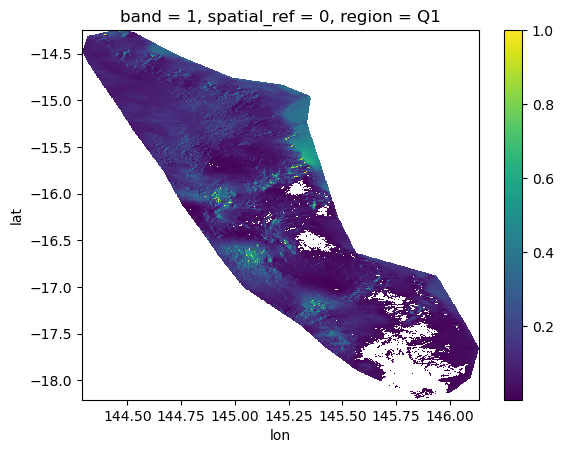

In [29]:
q1.where(q1>0).plot()

In [26]:
q1.mean()

<xarray.DataArray ()> Size: 8B
array(0.11178818)
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0
    region       <U3 12B 'Q1'

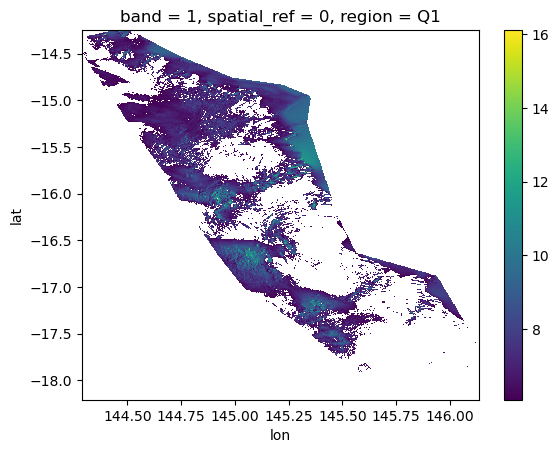

In [30]:
q1ws.where(q1ws > 6.08).plot()

In [25]:
q1ws.mean()

<xarray.DataArray ()> Size: 8B
array(6.08093309)
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0
    region       <U3 12B 'Q1'